In [ ]:
!pip install langchain-community
!pip install pypdf
!pip install faiss-gpu
!pip install accelerate
!pip install bitsandbytes
!pip install flash-attn
!pip install -U sentence-transformers
!pip install pdfplumber
!pip install gradio
!pip install unstructured
!pip install "unstructured[pdf]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 711.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 578.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_c

In [ ]:
%load_ext cudf.pandas
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_community.document_loaders import UnstructuredFileLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
import pandas as pd
import numpy as np
import gradio as gr
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.document_loaders import PDFPlumberLoader
import re
from google.colab import drive
drive.mount('/content/drive')


The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# drive_model_path = '/content/drive/My Drive/HuggingFaceLLM'
# if not os.path.exists(drive_model_path):
#   os.makedirs(drive_model_path)

# model_name = "Alibaba-NLP/gte-large-en-v1.5"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)
# model.save_pretrained(drive_model_path)
# print(f"Model saved to {drive_model_path}")

## Data Loaders

In [ ]:
#unstrudctured data loader
loader = UnstructuredFileLoader("/content/NVIDIAAn.pdf")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
udata  = [splits[i].page_content for i in range(len(splits))]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
udata[0].split("\n")

['NVIDIA Announces Financial Results for First Quarter Fiscal 2024',
 '',
 'Quarterly revenue of $7.19 billion, up 19% from previous quarter',
 '',
 'Record Data Center revenue of $4.28 billion',
 '',
 'Second quarter fiscal 2024 revenue outlook of $11.00 billion',
 '',
 'NVIDIA (NASDAQ: NVDA) today reported revenue for the first quarter ended April 30, 2023, of $7.19 billion, down 13% from a year ago and up 19% from the previous quarter.',
 '',
 'GAAP earnings per diluted share for the quarter were $0.82, up 28% from a year ago and up 44% from the previous quarter. Non-GAAP earnings per diluted share were $1.09, down 20% from a year ago and up 24% from the previous quarter.',
 '',
 '“The computer industry is going through two simultaneous transitions — accelerated computing and generative AI,” said Jensen Huang, founder and CEO of NVIDIA.',
 '',
 '“A trillion dollars of installed global data center infrastructure will transition from general purpose to accelerated computing as compani

In [ ]:
loader = PDFPlumberLoader("/content/NVIDIAAn.pdf")
docs = loader.load()
no_over_lap_text_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, chunk_overlap=0)
no_over_splits = no_over_lap_text_splitter.split_documents(docs)
no_overlap_data = [no_over_splits[i].page_content for i in range(len(no_over_splits))]

In [ ]:
no_overlap_data[1].split("\n")

['Revenue is expected to be $11.00 billion, plus or minus 2%.',
 'GAAP and non-GAAP gross margins are expected to be 68.6% and 70.0%, respectively, plus or minus 50 basis points.',
 'GAAP and non-GAAP operating expenses are expected to be approximately $2.71 billion and $1.90 billion,',
 'respectively.',
 'GAAP and non-GAAP other income and expense are expected to be an income of approximately $90 million,',
 'excluding gains and losses from non-affiliated investments.',
 'GAAP and non-GAAP tax rates are expected to be 14.0%, plus or minus 1%, excluding any discrete items.',
 'Highlights',
 'NVIDIA achieved progress since its previous earnings announcement in these areas:',
 'Data Center',
 'First-quarter revenue was a record $4.28 billion, up 14% from a year ago and up 18% from the previous quarter.',
 'Launched four inference platforms that combine the company’s full-stack inference software with the latest NVIDIA Ada,',
 'NVIDIA Hopper™ and NVIDIA Grace Hopper™ processors.',
 'Annou

In [ ]:
# loader = PDFPlumberLoader("/content/NVIDIAAn.pdf")
# docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, chunk_overlap=500)
splits = text_splitter.split_documents(docs)
data = [splits[i].page_content for i in range(len(splits))]

In [ ]:
data[1].split("\n")

['Revenue is expected to be $11.00 billion, plus or minus 2%.',
 'GAAP and non-GAAP gross margins are expected to be 68.6% and 70.0%, respectively, plus or minus 50 basis points.',
 'GAAP and non-GAAP operating expenses are expected to be approximately $2.71 billion and $1.90 billion,',
 'respectively.',
 'GAAP and non-GAAP other income and expense are expected to be an income of approximately $90 million,',
 'excluding gains and losses from non-affiliated investments.',
 'GAAP and non-GAAP tax rates are expected to be 14.0%, plus or minus 1%, excluding any discrete items.',
 'Highlights',
 'NVIDIA achieved progress since its previous earnings announcement in these areas:',
 'Data Center',
 'First-quarter revenue was a record $4.28 billion, up 14% from a year ago and up 18% from the previous quarter.',
 'Launched four inference platforms that combine the company’s full-stack inference software with the latest NVIDIA Ada,',
 'NVIDIA Hopper™ and NVIDIA Grace Hopper™ processors.',
 'Annou

In [ ]:
len(no_overlap_data),len(data)

(12, 23)

##model Embeddings

In [ ]:

model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")

passage_embeddings = model.encode(no_overlap_data)


In [ ]:

len(passage_embeddings),len(passage_embeddings[0])


(12, 768)

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_model_path = '/content/drive/MyDrive/HuggingFaceModels/'
embed_tokenizer = AutoTokenizer.from_pretrained(embed_model_path)
embed_model = AutoModel.from_pretrained(embed_model_path, trust_remote_code=True, token="")
embed_model.to(device)
def process_in_batches(data, batch_size,is_query=False):
  if is_query:
    batch_dict = embed_tokenizer(data, max_length=8192, padding=True, truncation=True, return_tensors='pt')
    batch_dict = {k: v.to(device) for k, v in batch_dict.items()}
    with torch.no_grad():
        outputs = embed_model(**batch_dict)
        embeddings = outputs.last_hidden_state[:, 0].cpu()
    normalized_embeddings  = F.normalize(embeddings, p=2, dim=1)
    return embeddings.numpy().flatten(),normalized_embeddings.numpy().flatten()
  else :
    embeddings_list = []
    normalized_embeddings_list = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_dict = embed_tokenizer(batch_data, max_length=8192, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

        with torch.no_grad():
            outputs = embed_model(**batch_dict)
            embeddings = outputs.last_hidden_state[:, 0].cpu()
            normalized_embeddings  = F.normalize(embeddings, p=2, dim=1)
            embeddings_list.append(embeddings)
            normalized_embeddings_list.append(normalized_embeddings)
    return torch.cat(embeddings_list, dim=0), torch.cat(normalized_embeddings_list, dim=0)

embeddings, normalized_embeddings = process_in_batches(data, batch_size=2, is_query=False)

torch.cuda.empty_cache()
len(embeddings)

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/57.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


12

In [ ]:
df1 = pd.DataFrame(embeddings)
df2 = pd.DataFrame(normalized_embeddings)
df1["text"] = data
df2["text"] = data

In [ ]:
df1

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,text
0,0.857680,0.342077,-0.418569,0.001983,-0.593778,0.297711,-1.156563,-0.135797,-0.491296,0.202726,...,-0.090225,0.216011,-0.417802,-1.379127,-0.040056,0.085791,-0.193753,-0.516647,0.881613,NVIDIA Announces Financial Results for First Q...
1,0.863218,0.471971,-0.021550,-0.253021,-0.136180,-0.504467,-1.092835,-0.492843,-0.496059,0.092909,...,-0.500341,0.021716,1.184639,-0.757163,-0.406157,0.278482,0.510843,-0.631333,1.012986,"Revenue is expected to be $11.00 billion, plus..."
2,0.459240,0.115796,-0.735571,-0.365959,-0.272577,-0.284183,-1.018723,-0.643888,0.354025,-0.264921,...,-0.398710,0.540502,0.444598,-0.876692,-1.028119,0.465917,1.369560,-0.941950,0.588478,accelerate their AI initiatives.\nGaming\nFirs...
3,0.606000,0.648465,-0.075505,-0.907935,-0.417038,0.652966,-1.032805,0.673038,0.520154,-0.326346,...,-0.666827,-0.233109,0.771269,-0.304343,0.047345,0.278447,0.558753,-0.436631,0.107958,conference call will be accessible at NVIDIA’s...
4,0.571764,-0.197909,-0.187680,-0.674871,0.399586,1.093813,0.115548,0.974416,0.397938,-0.946352,...,-0.709955,0.025593,1.001627,0.277075,-0.347293,0.557807,0.712218,0.393751,-0.099162,CONDENSED CONSOLIDATED STATEMENTS OF INCOME\n(...
5,0.374660,0.686416,0.164792,-0.002602,-0.272279,0.467121,-0.736897,0.972715,-0.116128,-0.412450,...,-0.010391,0.497951,0.515578,-0.826423,-0.283376,-0.275202,0.166524,-0.523335,0.581423,Basic $ 0.83 $ 0.65\nDiluted $ 0.82 $ 0.64\nWe...
6,0.803987,0.745125,-0.527940,-0.539093,-0.136347,0.909666,-0.974468,1.016014,0.391885,-0.683064,...,-0.933898,-0.180304,0.961072,-0.401187,-0.305766,0.527265,-0.140005,-0.408230,-0.068333,Long-term operating lease liabilities 939 902\...
7,0.551798,0.877609,0.332707,-0.754551,-0.092583,0.546508,-1.597433,0.903544,-0.060881,-0.424581,...,0.072771,-0.198797,0.871813,-0.552158,-0.336533,-0.415407,0.135378,0.124286,-0.318897,Purchase related to property and equipment and...
8,-0.283421,0.383013,-0.041884,0.140007,-0.165830,0.203436,-0.777614,0.483046,1.330647,0.209477,...,0.196815,0.623905,0.953392,-1.081899,-0.872569,-0.035704,0.885259,-0.000091,0.200867,"GAAP income from operations $ 2,140 $ 1,257 $ ..."
9,1.187208,0.948271,-0.586133,-0.501828,0.178080,-0.369999,-0.538479,-0.410849,0.239683,0.483034,...,-0.827606,0.744318,0.522952,-0.963062,-0.893439,0.579952,0.294717,-0.257505,0.833230,Research and development $ 524 $ 527 $ 384\nSa...


In [ ]:
df2

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,text
0,0.035780,0.014270,-0.017461,0.000083,-0.024771,0.012420,-0.048248,-0.005665,-0.020495,0.008457,...,-0.003764,0.009011,-0.017429,-0.057533,-0.001671,0.003579,-0.008083,-0.021553,0.036778,NVIDIA Announces Financial Results for First Q...
1,0.035969,0.019666,-0.000898,-0.010543,-0.005674,-0.021020,-0.045537,-0.020536,-0.020670,0.003871,...,-0.020849,0.000905,0.049362,-0.031550,-0.016924,0.011604,0.021286,-0.026307,0.042210,"Revenue is expected to be $11.00 billion, plus..."
2,0.019184,0.004837,-0.030727,-0.015287,-0.011386,-0.011871,-0.042555,-0.026897,0.014789,-0.011067,...,-0.016655,0.022578,0.018572,-0.036622,-0.042948,0.019463,0.057211,-0.039348,0.024583,accelerate their AI initiatives.\nGaming\nFirs...
3,0.025235,0.027004,-0.003144,-0.037809,-0.017366,0.027191,-0.043009,0.028027,0.021660,-0.013590,...,-0.027768,-0.009707,0.032118,-0.012674,0.001972,0.011595,0.023268,-0.018182,0.004496,conference call will be accessible at NVIDIA’s...
4,0.023807,-0.008241,-0.007815,-0.028101,0.016638,0.045545,0.004811,0.040573,0.016570,-0.039405,...,-0.029561,0.001066,0.041706,0.011537,-0.014461,0.023226,0.029656,0.016395,-0.004129,CONDENSED CONSOLIDATED STATEMENTS OF INCOME\n(...
5,0.015606,0.028592,0.006864,-0.000108,-0.011341,0.019457,-0.030695,0.040517,-0.004837,-0.017180,...,-0.000433,0.020742,0.021476,-0.034424,-0.011804,-0.011463,0.006936,-0.021799,0.024219,Basic $ 0.83 $ 0.65\nDiluted $ 0.82 $ 0.64\nWe...
6,0.033576,0.031118,-0.022048,-0.022514,-0.005694,0.037990,-0.040696,0.042431,0.016366,-0.028526,...,-0.039002,-0.007530,0.040137,-0.016755,-0.012770,0.022020,-0.005847,-0.017049,-0.002854,Long-term operating lease liabilities 939 902\...
7,0.022866,0.036368,0.013787,-0.031268,-0.003837,0.022647,-0.066197,0.037442,-0.002523,-0.017594,...,0.003016,-0.008238,0.036127,-0.022881,-0.013946,-0.017214,0.005610,0.005150,-0.013215,Purchase related to property and equipment and...
8,-0.011734,0.015858,-0.001734,0.005797,-0.006866,0.008423,-0.032195,0.019999,0.055092,0.008673,...,0.008149,0.025831,0.039472,-0.044793,-0.036126,-0.001478,0.036652,-0.000004,0.008316,"GAAP income from operations $ 2,140 $ 1,257 $ ..."
9,0.049569,0.039593,-0.024473,-0.020953,0.007435,-0.015449,-0.022483,-0.017154,0.010007,0.020168,...,-0.034555,0.031077,0.021835,-0.040211,-0.037304,0.024215,0.012305,-0.010752,0.034790,Research and development $ 524 $ 527 $ 384\nSa...


In [ ]:
df1.to_csv("euclidean_embeddings.csv",index=False)
df2.to_csv("cosine_embeddings.csv",index=False)

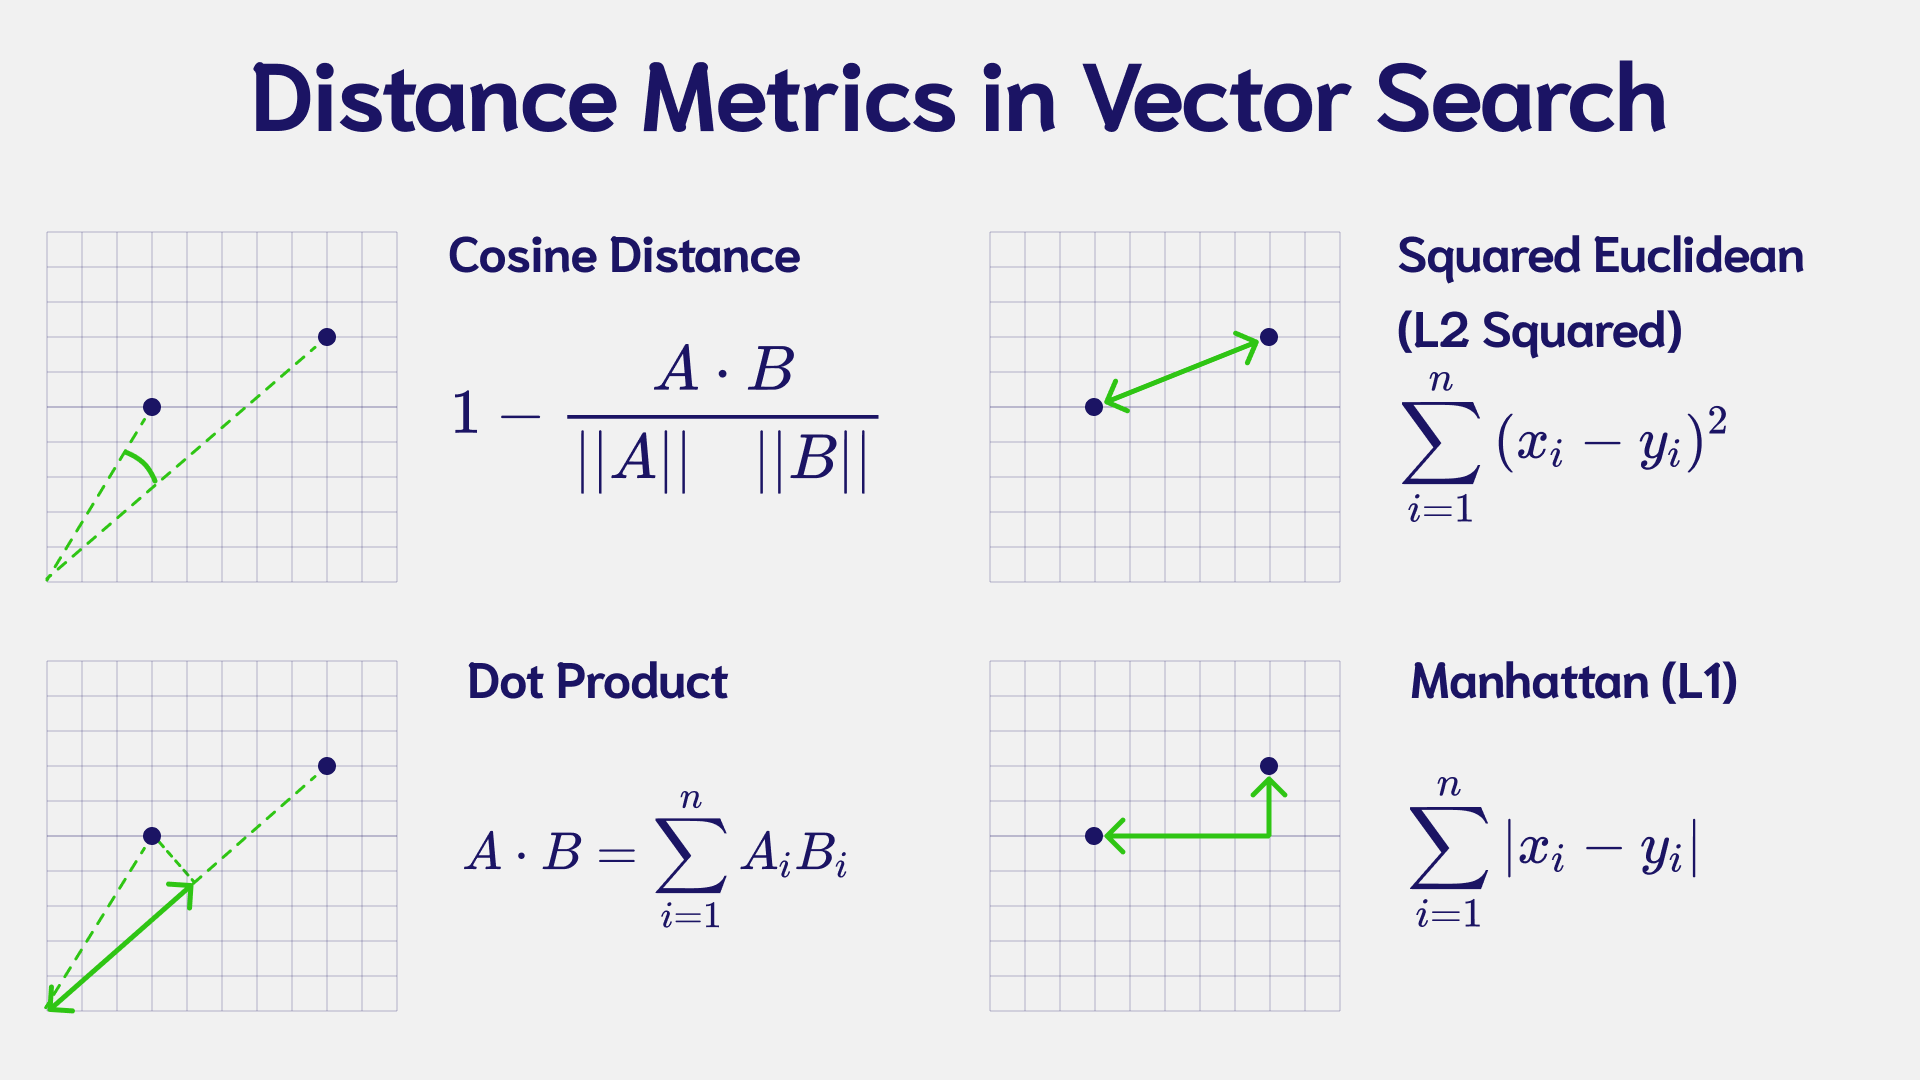

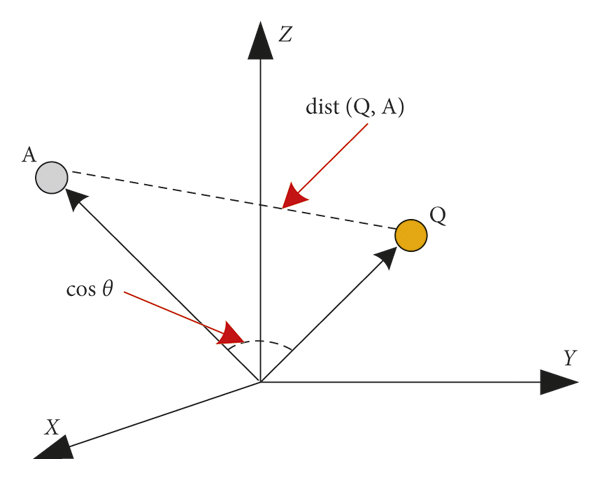

In [ ]:
import faiss
embeddings = np.vstack(embeddings).astype(np.float32)
normalized_embeddings = np.vstack(normalized_embeddings).astype(np.float32)

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)## this is normal Eclidian distance

res = faiss.StandardGpuResources()
normalized_dimension = normalized_embeddings.shape[1]
index_cos = faiss.GpuIndexFlatIP(res,normalized_dimension) ## cosine

##vector index
index.add(embeddings)
index_cos.add(normalized_embeddings)


def search(query_embedding,normalized_query_embeddings, k):
    query_embedding = np.array(query_embedding).reshape(1, -1).astype(np.float32)
    normalized_query_embeddings = np.array(normalized_query_embeddings).reshape(1, -1).astype(np.float32)
    distance, indices = index.search(query_embedding, k)
    cos_sim,cos_indices = index_cos.search(normalized_query_embeddings, k)
    return distance, indices,cos_sim, cos_indices

In [ ]:
query_embedding,normalized_query_embeddings =  process_in_batches([input()],batch_size=1,is_query=True)
distance, indices,cos_sim, cos_indices = search(query_embedding,normalized_query_embeddings, k=10)

what us Non-GAAP profit of nvidia


In [ ]:
distance, indices,cos_sim, cos_indices

(array([[286.74393, 299.04086, 299.0987 , 332.1126 , 383.71213, 397.73062,
         411.6757 , 417.54492, 453.49567, 459.17474]], dtype=float32),
 array([[ 3,  1,  9,  0,  6,  2, 10,  7,  5, 11]]),
 array([[0.7527705 , 0.7420094 , 0.7414523 , 0.7131508 , 0.66822743,
         0.65601885, 0.64172864, 0.64122677, 0.60888284, 0.6002838 ]],
       dtype=float32),
 array([[ 3,  1,  9,  0,  6,  2,  7, 10,  5, 11]]))

In [ ]:
# Load models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_model_path = '/content/drive/MyDrive/HuggingFaceModels/'
embed_tokenizer = AutoTokenizer.from_pretrained(embed_model_path)
embed_model = AutoModel.from_pretrained(embed_model_path, trust_remote_code=True, token="")
embed_model.to(device)

llm_model = AutoModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/HuggingFaceLLM",
    device_map="cuda",
    torch_dtype="auto",
    load_in_4bit=True,
    trust_remote_code=True,
)
llm_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/HuggingFaceLLM")


configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Special tokens have been add

In [ ]:
def combine_context(context_list):
    return "\n".join(context_list)

In [ ]:
query = input()
query_embedding,normalized_query_embeddings =  process_in_batches([query],batch_size=1,is_query=True)
distance, indices,cos_sim, cos_indices = search(query_embedding,normalized_query_embeddings, k=4)

context_list = df2.iloc[cos_indices[0]]["text"].tolist()
context = combine_context(context_list)
messages = [
    {"role": "system", "content": "You are a helpful AI assistant explain you approach as well"},
    {"role": "user", "content": f"Context:\n{context}\n\nQuestion:\n{query}"},
]

pipe = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=llm_tokenizer,
)

generation_args = {
    "max_new_tokens": 5000,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)

torch.cuda.empty_cache()

what is GAAP profit of nvidia


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
output[0]['generated_text']

" NVIDIA's GAAP profit for the first quarter of fiscal 2024 was $2,043 million."

## complete rags with Gradio interface

In [ ]:
%load_ext cudf.pandas
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_community.document_loaders import UnstructuredFileLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd
import numpy as np
import gradio as gr
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.document_loaders import PDFPlumberLoader
import re
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to process in batches
def process_in_batches(data, batch_size, is_query=False):
    if is_query:
        batch_dict = embed_tokenizer(data, max_length=8192, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}
        with torch.no_grad():
            outputs = embed_model(**batch_dict)
            embeddings = outputs.last_hidden_state[:, 0].cpu()
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings.numpy().flatten(), normalized_embeddings.numpy().flatten()
    else:
        embeddings_list = []
        normalized_embeddings_list = []
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i + batch_size]
            batch_dict = embed_tokenizer(batch_data, max_length=8192, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}
            with torch.no_grad():
                outputs = embed_model(**batch_dict)
                embeddings = outputs.last_hidden_state[:, 0].cpu()
                normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
                embeddings_list.append(embeddings)
                normalized_embeddings_list.append(normalized_embeddings)
        return torch.cat(embeddings_list, dim=0), torch.cat(normalized_embeddings_list, dim=0)

# Function to combine context into a single string
def combine_context(context_list):
    return "\n".join(context_list)

# Function for sentence transformer similarity
def sentence_transformer_similarity(query):
    model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")
    query_embedding = model.encode(query)
    passage_embeddings = model.encode(data)
    similarity = np.dot(passage_embeddings, query_embedding)
    return similarity

# Load models and data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_model_path = '/content/drive/MyDrive/HuggingFaceModels/'
embed_tokenizer = AutoTokenizer.from_pretrained(embed_model_path)
embed_model = AutoModel.from_pretrained(embed_model_path, trust_remote_code=True, token="")
embed_model.to(device)

llm_model = AutoModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/HuggingFaceLLM",
    device_map="cuda",
    torch_dtype="auto",
    load_in_4bit=True,
    trust_remote_code=True,
)
llm_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/HuggingFaceLLM")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` 

In [ ]:
loader = PDFPlumberLoader("/content/NVIDIAAn.pdf")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
data = [splits[i].page_content for i in range(len(splits))]

embeddings, normalized_embeddings = process_in_batches(data, batch_size=2, is_query=False)

torch.cuda.empty_cache()
df1 = pd.DataFrame(embeddings)
df2 = pd.DataFrame(normalized_embeddings)
df1["text"] = data
df2["text"] = data

embeddings = np.vstack(embeddings).astype(np.float32)
normalized_embeddings = np.vstack(normalized_embeddings).astype(np.float32)
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
res = faiss.StandardGpuResources()
normalized_dimension = normalized_embeddings.shape[1]
index_cos = faiss.GpuIndexFlatIP(res, normalized_dimension)
index.add(embeddings)
index_cos.add(normalized_embeddings)

def generate_queries(query, num_queries=4):
    prompt = """Example Flow:
Original query: "What is NVIDIA's primary business focus?"
Generated variations:
1.What core industry does NVIDIA predominantly operate in?
2.What is the main area of expertise for NVIDIA in the technology sector?
3.Which market segment is at the heart of NVIDIA's business operations?
4.What primary products or services define NVIDIA's business strategy?"""
    messages_euclidean = [{"role": "system", "content":f"As a search assistant, your task is to generate 4 different variations of the following search query to aid in comprehensive semantic retrieval. Each variation should focus on slightly different aspects or rephrasing of the original query to ensure diverse retrieval results. Please provide each variation on a new line without any additional text or numbering.\n{prompt}"},
                          {"role": "user", "content": f"User Question:{query} now give me generate 4 different variations of the following search query "},]
    pipe = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=llm_tokenizer,
    )
    generation_args = {
        "max_new_tokens": 400,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }
    generated_queries = pipe(messages_euclidean, **generation_args)[0]['generated_text']
    torch.cuda.empty_cache()
    lines = generated_queries.split("\n")
    question_pattern = re.compile(r'^\d+\.\s*(.*)')
    questions = [line.strip() for line in lines if question_pattern.match(line.strip())]
    return questions


def search_and_generate(query):
    query_embedding, normalized_query_embeddings = process_in_batches([query], batch_size=1, is_query=True)

    # Euclidean distance search
    distance, indices = index.search(query_embedding.reshape(1, -1).astype(np.float32), k=4)
    context_list_euclidean = df2.iloc[indices[0]]["text"].tolist()
    context_euclidean = combine_context(context_list_euclidean)
    indices_euclidean = indices[0].tolist()
    prompt_rags = """Prompt:-Given the following 'Context' generate a detailed response to the 'User Question."""
    messages_euclidean = [
        {"role": "system", "content": "You are a helpful AI assistant"},
        {"role": "user", "content": f"{prompt_rags}\n\n\n'Context':\n\n{context_euclidean}\n\n\n 'User Question':\n{query}"},
    ]
    pipe = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=llm_tokenizer,
    )
    generation_args = {
        "max_new_tokens": 1000,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }
    output_euclidean = pipe(messages_euclidean, **generation_args)[0]['generated_text']
    torch.cuda.empty_cache()

    # Cosine similarity search
    cos_sim, cos_indices = index_cos.search(normalized_query_embeddings.reshape(1, -1).astype(np.float32), k=4)
    context_list_cosine = df2.iloc[cos_indices[0]]["text"].tolist()
    context_cosine = combine_context(context_list_cosine)
    indices_cosine = cos_indices[0].tolist()
    #If the context does not contain the necessary information to answer the question, acknowledge that and provide a response based on your general knowledge.
    messages_cosine = [
        {"role": "system", "content": "You are a helpful AI assistant"},
        {"role": "user", "content": f"{prompt_rags}\n\n\n'Context':\n{context_cosine}\n\n\n\n'User Question':\n{query}"},
    ]
    output_cosine = pipe(messages_cosine, **generation_args)[0]['generated_text']
    torch.cuda.empty_cache()

    # Sentence transformer similarity
    similarity = sentence_transformer_similarity(query)
    top4_values, top4_indices = torch.topk(torch.tensor(similarity), 4)
    context_list_sentence = df2.iloc[top4_indices]["text"].tolist()
    context_sentence = combine_context(context_list_sentence)
    indices_sentence = top4_indices.tolist()
    messages_sentence = [
        {"role": "system", "content": "You are a helpful AI assistant. Given the following 'context', generate a detailed response to the 'User Question"},
        {"role": "user", "content": f"{prompt_rags}\n\n\nContext:\n{context_sentence}\n\n\n\n'User Question':\n{query}"},
    ]
    output_sentence_transformer = pipe(messages_sentence, **generation_args)[0]['generated_text']
    torch.cuda.empty_cache()

     # MultiQueryRetriever (cosine similarity only)
    generated_queries = generate_queries(query)
    all_contexts = []
    all_indices = []

    for generated_query in generated_queries:
        norm_query_embedding, norm_query_embeddings = process_in_batches([generated_query], batch_size=1, is_query=True)
        cos_sim, cos_indices = index_cos.search(norm_query_embeddings.reshape(1, -1).astype(np.float32), k=4)
        all_contexts.extend(df2.iloc[cos_indices[0]]["text"].tolist())
        all_indices.extend(cos_indices[0].tolist())
        torch.cuda.empty_cache()

    # Removing duplicates
    unique_indices = list(set(all_indices))
    unique_contexts = [df2.iloc[i]["text"] for i in unique_indices]

    combined_multi_query_context = combine_context(unique_contexts)
    messages_multi_query = [
        {"role": "system", "content": "You are a helpful AI assistant. Given the following 'context', generate a detailed response to the 'User Question"},
        {"role": "user", "content": f"{prompt_rags}\n\n\nContext:\n{combined_multi_query_context}\n\n\n\n'User Question':{query}"},

    ]
    output_multi_query = pipe(messages_multi_query, **generation_args)[0]['generated_text']
    torch.cuda.empty_cache()

    return (output_euclidean,
            f"Context:\n{context_euclidean}\n\nIndices:\n{indices_euclidean}",
            output_cosine,
            f"Context:\n{context_cosine}\n\nIndices:\n{indices_cosine}",
            output_sentence_transformer,
            f"Context:\n{context_sentence}\n\nIndices:\n{indices_sentence}",
            output_multi_query,
            f"quries :-\n{generated_queries}Context:\n{combined_multi_query_context}\n\nIndices:\n{unique_indices}")

# Gradio interface
iface = gr.Interface(
    fn=search_and_generate,
    inputs="text",
    outputs=[
        gr.Textbox(label="Output based on Euclidean distance"),
        gr.Textbox(label="Euclidean Context and Indices"),
        gr.Textbox(label="Output based on cosine similarity"),
        gr.Textbox(label="Cosine Context and Indices"),
        gr.Textbox(label="Output based on sentence transformer similarity"),
        gr.Textbox(label="Sentence Transformer Context and Indices"),
        gr.Textbox(label="Output based on MultiQueryRetriever (cosine similarity)"),
        gr.Textbox(label="MultiQueryRetriever Context and Indices"),
    ],
    title="Chatbot with Multiple Outputs",
    description="Enter a query and get four different responses based on different similarity measures, along with context and indices."
)

# Launch the interface
iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a4b165f209400bd73a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a4b165f209400bd73a.gradio.live
